In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install pyspark

     |████████████████████████████████| 281.3 MB 39 kB/s 
     |████████████████████████████████| 198 kB 15.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=583abd0486c7795afda1eaa1e5b0b7cc4a2baff32e5bfaae264508a1ee43e71e
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


13주 iris데이터 회귀분석
앞서 사용했던 iris데이터를 사용해서 회귀분석을 해보자.

iris데이터는 아래 URL에서 읽어올 수 있다.



```

import pandas as pd

file_name = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"

iris = pd.read_csv(file_name, names=["sepal_length","sepal_width","petal_length", "petal_width","species"])

```



독립변수는 petal_length 컬럼, 종속변수는 petal_width 컬럼으로 해보자.

* (1) DataFrame 생성

* (2) 회귀선 그래프

* (3) Spark를 사용하여 회귀분석하고 계수 출력

* (4) 실제와 예측 출력

* (4) 정확성 평가하고 출력



In [4]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

In [5]:
import pandas as pd

file_name = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"

iris = pd.read_csv(file_name, names=["sepal_length","sepal_width","petal_length", "petal_width","species"])

## (1) DataFrame 생성

In [6]:
irisDf=spark.createDataFrame(iris)

In [7]:
irisDf.printSchema()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)



## (2) 회귀선 그래프

In [8]:
from sklearn import linear_model
x=iris['petal_length']
y=iris['petal_width']

In [9]:
import numpy as np
x=np.array([x,np.ones(len(x))])#matrix inverse
x=x.T

In [10]:
x.shape
x[1]

array([1.4, 1. ])

w

In [11]:
w1, w0=np.dot(np.linalg.inv(np.dot(x.T, x)), np.dot(x.T, y)) #1이 뒤에있으니까 2번째가 w0이다
print("w1:{} w0:{}".format(w1,w0))

w1:0.4164191322854026 w0:-0.3665140452167337


yhat

In [12]:
yhat = w0*x[:,1] + w1*x[:,0]

In [13]:
alpha = 0.002
theta=np.array(np.ones([x.shape[1]]))
def gradientDescent(x,y,theta,alpha,numIterations):
    for i in range(numIterations):
        #i+=1
        h=np.dot(x,theta)
        error=h-y
        cost=np.sum((h-y)**2)/len(x) #full MSE
        gradient=np.dot(x.T,error)*2/len(x) #w0,w1
        theta-=alpha*gradient
        if i%100==0:
            print("Iteration {0} | theta{1} Cost {2:.5f}".format(i,theta,cost))

    return theta


In [14]:
w1g, w0g=gradientDescent(x, y, theta, alpha, 10000) 

Iteration 0 | theta[0.93925787 0.98576   ] Cost 13.76907
Iteration 100 | theta[0.17401059 0.73508253] Cost 0.26058
Iteration 200 | theta[0.18966613 0.6619995 ] Cost 0.23261
Iteration 300 | theta[0.20469088 0.59384868] Cost 0.20822
Iteration 400 | theta[0.21872029 0.53021369] Cost 0.18696
Iteration 500 | theta[0.2318201  0.47079524] Cost 0.16842
Iteration 600 | theta[0.24405189 0.41531394] Cost 0.15226
Iteration 700 | theta[0.25547319 0.36350891] Cost 0.13817
Iteration 800 | theta[0.2661377  0.31513656] Cost 0.12589
Iteration 900 | theta[0.27609556 0.26996942] Cost 0.11517
Iteration 1000 | theta[0.2853936  0.22779513] Cost 0.10584
Iteration 1100 | theta[0.29407553 0.18841536] Cost 0.09769
Iteration 1200 | theta[0.30218219 0.15164495] Cost 0.09059
Iteration 1300 | theta[0.30975169 0.117311  ] Cost 0.08441
Iteration 1400 | theta[0.31681963 0.08525207] Cost 0.07901
Iteration 1500 | theta[0.32341923 0.05531741] Cost 0.07430
Iteration 1600 | theta[0.32958154 0.02736626] Cost 0.07020
Iteratio

yhat

In [15]:
yhatGV = w0g*x[:,1] + w1g*x[:,0]

Text(0.5, 0, 'petal_length')

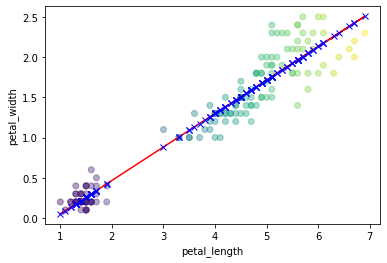

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

fig=plt.figure()
ax=fig.add_subplot(111)
ax.scatter(x[:,0],y,alpha=0.4,c=iris.petal_length)
plt.plot(x[:,0],yhatGV,'r-')
plt.plot(x[:,0],yhat,'bx')
ax.set_ylabel('petal_width') 
ax.set_xlabel('petal_length')

## (3) Spark를 사용하여 회귀분석하고 계수 출력

In [17]:
(trainDf, testDf) = irisDf.randomSplit([0.6, 0.4])

모델링

In [18]:
from pyspark.ml.feature import VectorAssembler
va = VectorAssembler(inputCols = ["petal_length"],
                                   outputCol = 'features')

In [20]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='petal_width', maxIter=10, regParam=0.3, elasticNetParam=0.8)


In [21]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[va,lr])

In [22]:
model = pipeline.fit(trainDf)
modelTrainDf = model.transform(trainDf)

계수 출력

In [23]:
print("Coefficients: {}".format(model.stages[-1].coefficients))
print("Intercept: {:.3f}".format(model.stages[-1].intercept)) #y절편

Coefficients: [0.2435073141404565]
Intercept: 0.253


## (4) 실제와 예측 출력

In [24]:
modelTestDf=model.transform(testDf)
modelTestDf.select('petal_width','prediction').show(10)

+-----------+------------------+
|petal_width|        prediction|
+-----------+------------------+
|        0.2|0.5939948700826704|
|        0.3|0.5939948700826704|
|        0.3|0.5939948700826704|
|        0.2|0.6426963329107618|
|        0.2|0.7157485271528987|
|        1.7|1.3488675439180855|
|        0.2|0.6426963329107618|
|        0.2|0.5939948700826704|
|        0.6|0.6426963329107618|
|        0.5|0.6670470643248074|
+-----------+------------------+
only showing top 10 rows



In [25]:
petal_l=modelTestDf.rdd.map(lambda x:x[3]).collect()
pred=modelTestDf.rdd.map(lambda x:x[6]).collect()

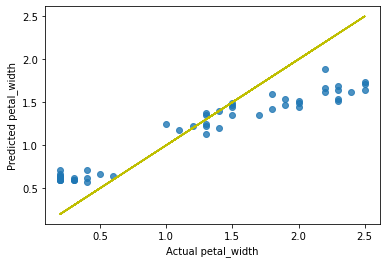

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

fig=plt.figure()
ax=fig.add_subplot(111)
ax.scatter(petal_l,pred,alpha=0.8)
ax.set_ylabel('Predicted petal_width') 
ax.set_xlabel('Actual petal_width')
ax.plot(petal_l,petal_l,'y')

## (5) 정확성 평가

In [27]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator=RegressionEvaluator(labelCol="petal_width", predictionCol="prediction", metricName="rmse")


In [28]:
rmse=evaluator.evaluate(modelTestDf)

In [29]:
f"Root Mean Squared Error (RMSE) on test data: {rmse:.3f}"

'Root Mean Squared Error (RMSE) on test data: 0.422'

R^2

In [30]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator=RegressionEvaluator(labelCol="petal_width", predictionCol="prediction", metricName="r2")


In [31]:
f"r2: {evaluator.evaluate(modelTestDf):.3f}"

'r2: 0.732'